# Insurance Conversion Propensity Modeling (Colab)

End-to-end notebook for ranking users by conversion propensity (`has_sale`) with **Average Precision (PR-AUC)** as the primary model-selection metric.

**Note:**

Including monthly_cost makes this a “propensity given the current offer/price” model, which is appropriate if personalization changes only the experience (copy, UI, recommendations) but not the price itself. If personalization can change discounts or the quoted price, be careful: the model may rely heavily on monthly_cost, so you may want to compare results with and without it to avoid feedback loops and to understand “intrinsic” buyer propensity.

## 0 — Setup

In [1]:
# Colab-friendly installs
!pip -q install lightgbm imbalanced-learn optuna optuna-integration shap joblib

import os
import random
import warnings
from dataclasses import dataclass

import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from imblearn.ensemble import BalancedRandomForestClassifier
from lightgbm import LGBMClassifier
from optuna.integration import lightgbm as optuna_lgb
from scipy import sparse
from sklearn.base import clone
from sklearn.calibration import calibration_curve
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    average_precision_score,
    brier_score_loss,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

warnings.filterwarnings('ignore')
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
plt.style.use('seaborn-v0_8-whitegrid')

print('Seed set to', SEED)

Seed set to 42


### Optional: choose CSV from your local machine (Colab upload popup)

In [2]:
# If running in Colab, this opens a file upload popup.
# If you skip it, notebook uses default DATA_PATH = 'data_(2).csv'.
DATA_PATH = 'data_(2).csv'

try:
    from google.colab import files
    uploaded = files.upload()  # popup selector
    if uploaded:
        DATA_PATH = next(iter(uploaded.keys()))
        print('Using uploaded file:', DATA_PATH)
    else:
        print('No file uploaded. Using default:', DATA_PATH)
except Exception:
    print('Not in Colab (or upload skipped). Using default:', DATA_PATH)

Saving data_(2).csv to data_(2) (1).csv
Using uploaded file: data_(2) (1).csv


## 1 — Load + sanity checks

In [3]:
df = pd.read_csv(DATA_PATH)
df['dt'] = pd.to_datetime(df['dt'])

print('Shape:', df.shape)
print('Columns:', list(df.columns))
print('Dtypes:', df.dtypes)

missing_tbl = df.isna().mean().sort_values(ascending=False).rename('missing_rate')
print('Missingness (%):', (missing_tbl * 100).round(2))

before_n, before_pos = len(df), int(df['has_sale'].sum())
dup_mask = df.duplicated(keep='first')
num_dups = int(dup_mask.sum())
df = df.loc[~dup_mask].copy()
after_n, after_pos = len(df), int(df['has_sale'].sum())

print(f"\nRemoved duplicates: {num_dups}")
print(f"Rows: {before_n} -> {after_n}")
print(f"Positive count: {before_pos} -> {after_pos}")
print(f"Positive rate: {before_n and before_pos/before_n:.4f} -> {after_n and after_pos/after_n:.4f}")

# per provided data facts

uniq_comm = df['commission_rate'].nunique(dropna=False)
print('commission_rate unique values:', uniq_comm)

df = df.drop(columns=['commission_rate'])
print('Dropped commission_rate. New shape:', df.shape)

Shape: (10000, 12)
Columns: ['id', 'dt', 'age', 'platform', 'state_id', 'monthly_cost', 'commission_rate', 'gender', 'session_time', 'membership_level', 'household_income', 'has_sale']
Dtypes: id                           int64
dt                  datetime64[ns]
age                          int64
platform                    object
state_id                     int64
monthly_cost               float64
commission_rate            float64
gender                      object
session_time                 int64
membership_level            object
household_income           float64
has_sale                     int64
dtype: object
Missingness (%): membership_level    10.38
platform            10.01
dt                   0.00
id                   0.00
age                  0.00
state_id             0.00
commission_rate      0.00
monthly_cost         0.00
gender               0.00
session_time         0.00
household_income     0.00
has_sale             0.00
Name: missing_rate, dtype: float64

Removed 

## 2 — EDA with figures (matplotlib)

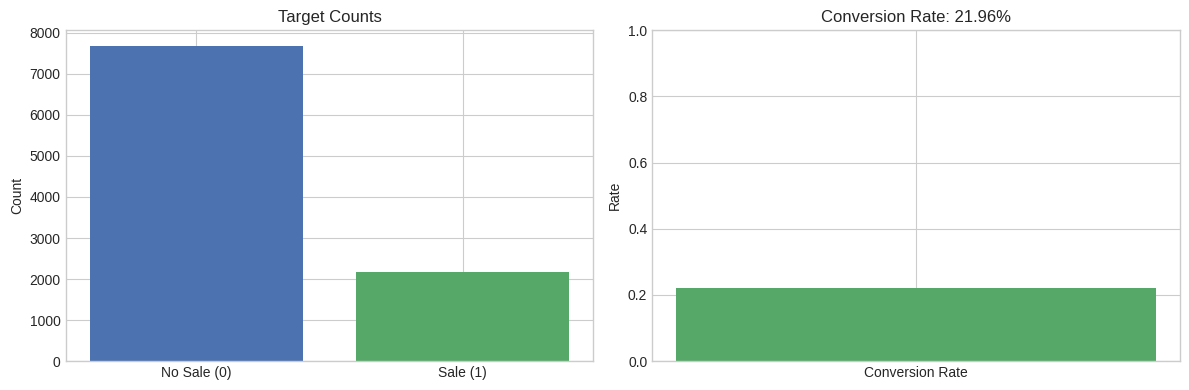

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
counts = df['has_sale'].value_counts().sort_index()
axes[0].bar(['No Sale (0)', 'Sale (1)'], counts.values, color=['#4C72B0', '#55A868'])
axes[0].set_title('Target Counts')
axes[0].set_ylabel('Count')

rate = df['has_sale'].mean()
axes[1].bar(['Conversion Rate'], [rate], color='#55A868')
axes[1].set_ylim(0, 1)
axes[1].set_title(f'Conversion Rate: {rate:.2%}')
axes[1].set_ylabel('Rate')
plt.tight_layout(); plt.show()

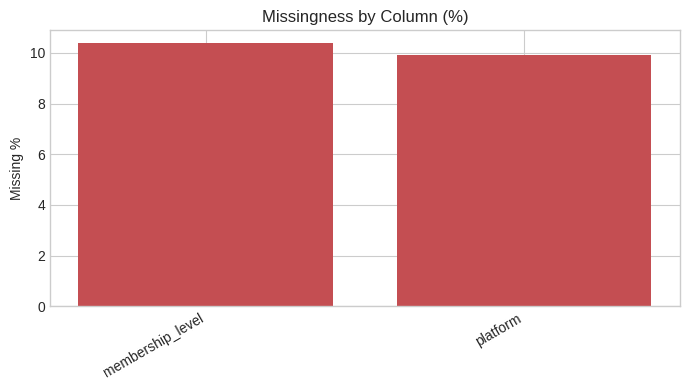

In [5]:
missing = df.isna().mean().sort_values(ascending=False)
missing = missing[missing > 0]
plt.figure(figsize=(7,4))
plt.bar(missing.index, missing.values*100, color='#C44E52')
plt.title('Missingness by Column (%)')
plt.ylabel('Missing %')
plt.xticks(rotation=30, ha='right')
plt.tight_layout(); plt.show()

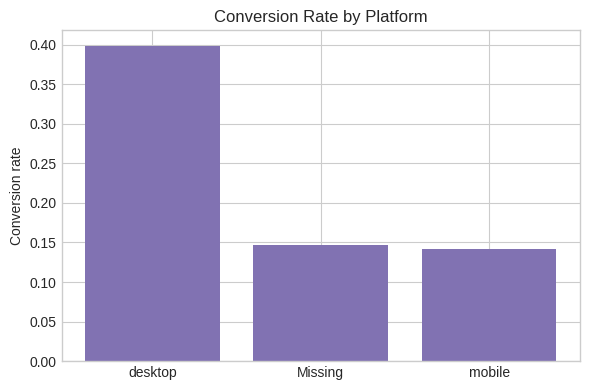

In [6]:
tmp = df.copy()
tmp['platform'] = tmp['platform'].fillna('Missing')
rate_by_platform = tmp.groupby('platform')['has_sale'].mean().sort_values(ascending=False)
plt.figure(figsize=(6,4))
plt.bar(rate_by_platform.index, rate_by_platform.values, color='#8172B2')
plt.title('Conversion Rate by Platform')
plt.ylabel('Conversion rate')
plt.tight_layout(); plt.show()

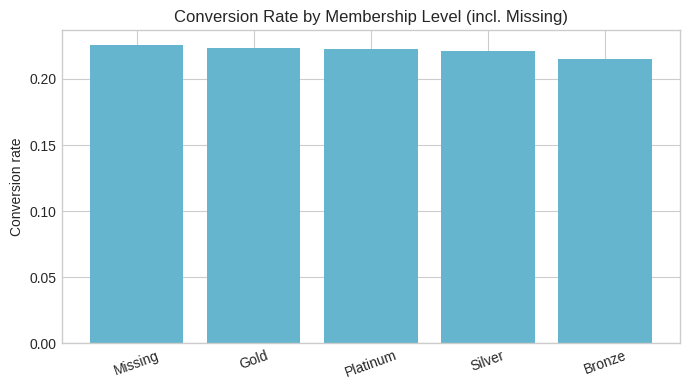

In [7]:
tmp = df.copy()
tmp['membership_level'] = tmp['membership_level'].fillna('Missing')
rate_by_member = tmp.groupby('membership_level')['has_sale'].mean().sort_values(ascending=False)
plt.figure(figsize=(7,4))
plt.bar(rate_by_member.index, rate_by_member.values, color='#64B5CD')
plt.title('Conversion Rate by Membership Level (incl. Missing)')
plt.ylabel('Conversion rate')
plt.xticks(rotation=20)
plt.tight_layout(); plt.show()

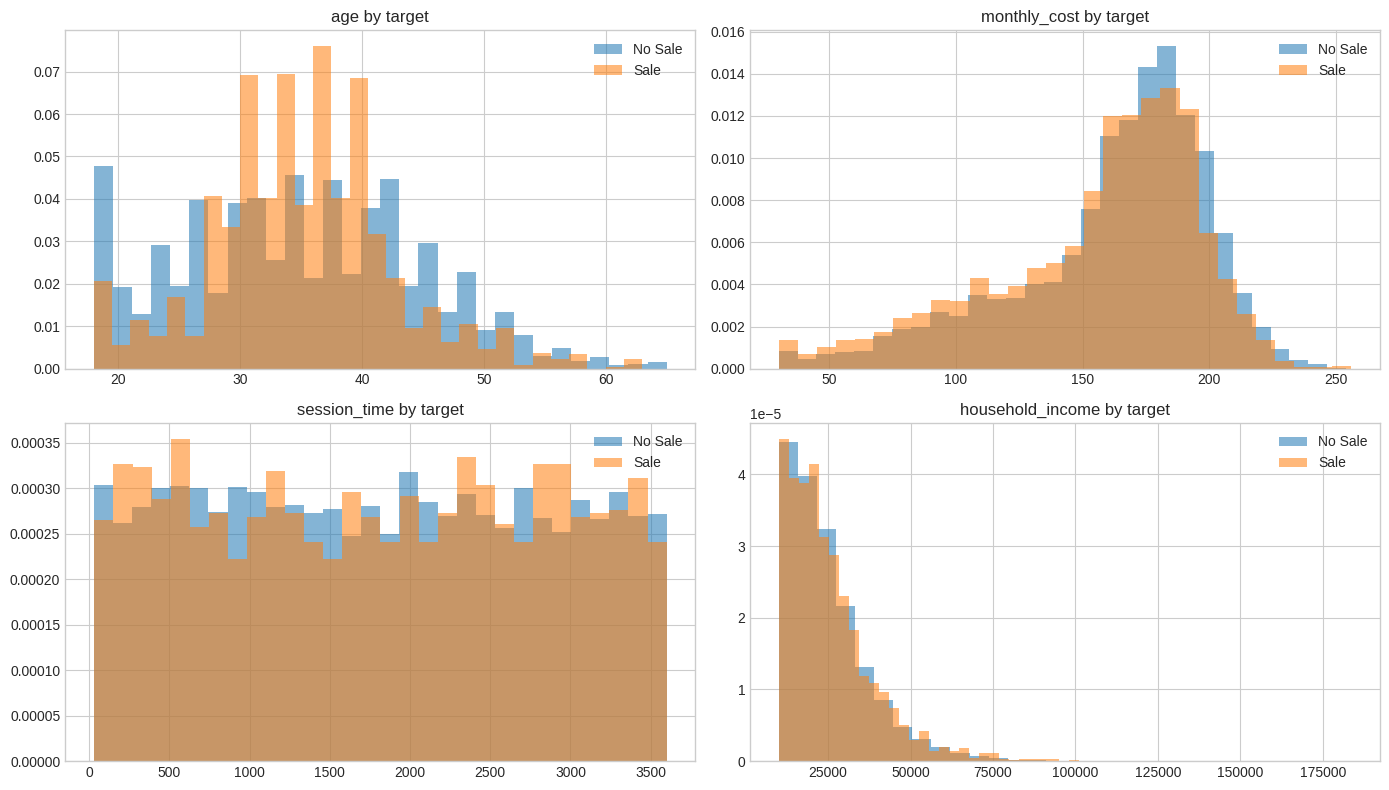

In [8]:
num_cols = ['age','monthly_cost','session_time','household_income']
fig, axes = plt.subplots(2,2, figsize=(14,8))
axes = axes.flatten()
for ax, c in zip(axes, num_cols):
    ax.hist(df.loc[df['has_sale']==0,c], bins=30, density=True, alpha=0.55, label='No Sale')
    ax.hist(df.loc[df['has_sale']==1,c], bins=30, density=True, alpha=0.55, label='Sale')
    ax.set_title(f'{c} by target')
    ax.legend()
plt.tight_layout(); plt.show()

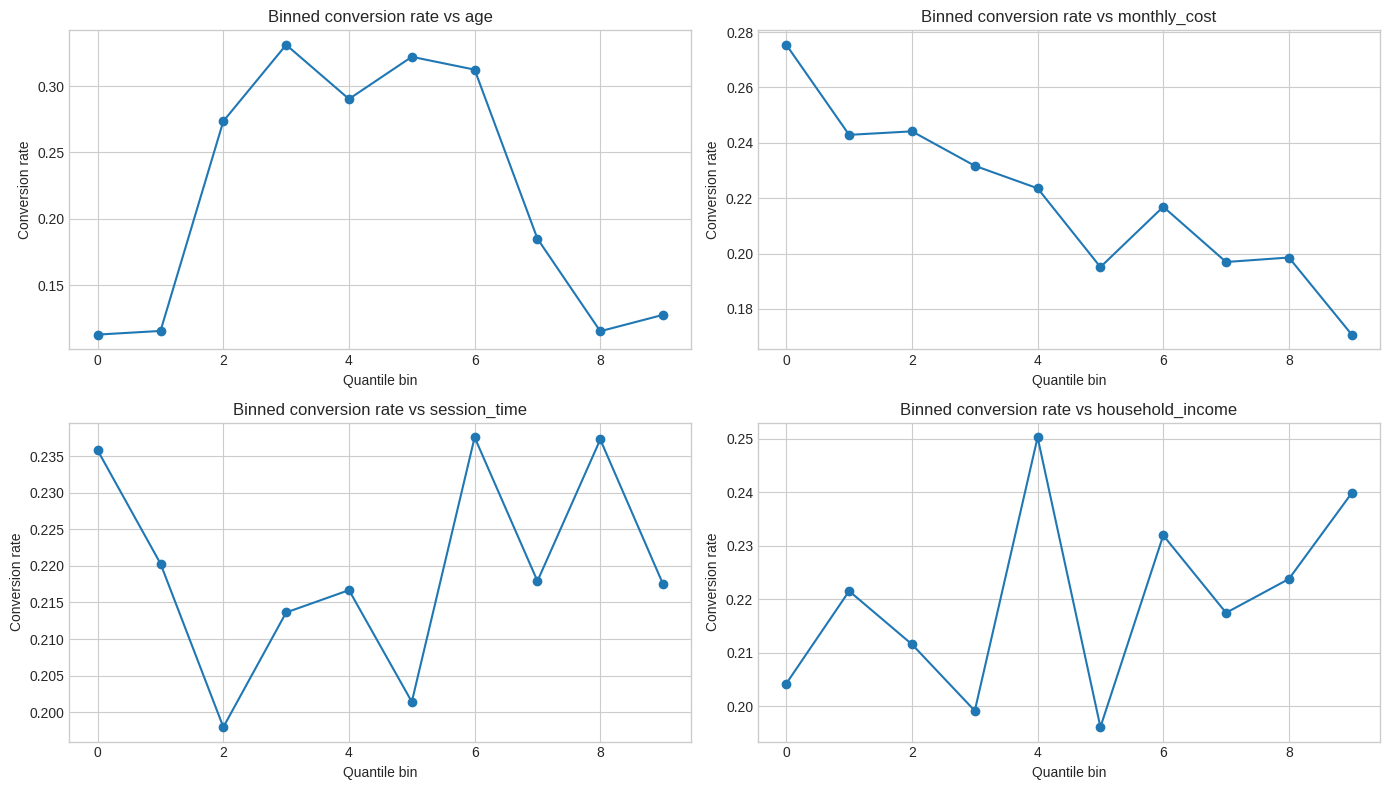

In [9]:
fig, axes = plt.subplots(2,2, figsize=(14,8))
axes = axes.flatten()
for ax, c in zip(axes, num_cols):
    b = pd.qcut(df[c], q=10, duplicates='drop')
    yb = df.groupby(b)['has_sale'].mean().reset_index(drop=True)
    ax.plot(range(len(yb)), yb.values, marker='o')
    ax.set_title(f'Binned conversion rate vs {c}')
    ax.set_xlabel('Quantile bin')
    ax.set_ylabel('Conversion rate')
plt.tight_layout(); plt.show()

**Quick insights:** conversion is imbalanced (~22%), platform is a strong differentiator, and some numeric features show non-linear conversion patterns.

## 3 — Feature engineering + preprocessing (sklearn Pipeline)

In [10]:
EPS = 1e-6
TARGET = 'has_sale'
ID_COL = 'id'

def add_features(frame: pd.DataFrame) -> pd.DataFrame:
    out = frame.copy()
    out['day_of_week'] = out['dt'].dt.dayofweek
    out['is_weekend'] = (out['day_of_week'] >= 5).astype(int)
    out['day_of_month'] = out['dt'].dt.day
    out['month'] = out['dt'].dt.month
    out['cost_income_ratio'] = out['monthly_cost'] / np.maximum(out['household_income'].values, EPS)
    return out

work_df = add_features(df)
DROP_COLS = [TARGET, ID_COL, 'dt']
X_all = work_df.drop(columns=DROP_COLS)
y_all = work_df[TARGET].astype(int)

num_features = X_all.select_dtypes(include=['number']).columns.tolist()
cat_features = X_all.select_dtypes(exclude=['number']).columns.tolist()

preprocessor_scaled = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), num_features),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore'))
    ]), cat_features)
])

# no scaler path for tree-based models / LightGBM tuner matrices
preprocessor_tree = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
    ]), num_features),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore'))
    ]), cat_features)
])

print('Numeric features:', num_features)
print('Categorical features:', cat_features)

Numeric features: ['age', 'state_id', 'monthly_cost', 'session_time', 'household_income', 'day_of_week', 'is_weekend', 'day_of_month', 'month', 'cost_income_ratio']
Categorical features: ['platform', 'gender', 'membership_level']


## 4 — Modeling & evaluation (ranking-focused)

In [11]:
def evaluate(y_true, y_score):
    return {
        'pr_auc': average_precision_score(y_true, y_score),
        'roc_auc': roc_auc_score(y_true, y_score)
    }

def precision_recall_at_k(y_true, y_score, k_frac):
    y_true = np.asarray(y_true)
    y_score = np.asarray(y_score)
    n = len(y_true)
    k = max(1, int(np.floor(n*k_frac)))
    idx = np.argsort(-y_score)[:k]
    precision = y_true[idx].mean()
    recall = y_true[idx].sum() / y_true.sum()
    threshold = np.sort(y_score)[-k]
    return {'k_frac':k_frac, 'k':k, 'threshold':float(threshold), 'precision@k':float(precision), 'recall@k':float(recall)}

# STRICT no-leak split:
# 1) train_val/test split (test untouched until final evaluation)
# 2) train/valid split inside train_val for model/tuner selection
X_train_val, X_test, y_train_val, y_test, idx_train_val, idx_test = train_test_split(
    X_all, y_all, work_df.index, test_size=0.2, stratify=y_all, random_state=SEED
)
X_train, X_valid, y_train, y_valid, idx_train, idx_valid = train_test_split(
    X_train_val, y_train_val, idx_train_val, test_size=0.25, stratify=y_train_val, random_state=SEED
)
print('Split sizes -> train:',len(X_train),'valid:',len(X_valid),'test:',len(X_test))

models = {
    'LogisticRegression': Pipeline([
        ('prep', preprocessor_scaled),
        ('model', LogisticRegression(max_iter=3000, class_weight='balanced', random_state=SEED))
    ]),
    'BalancedRandomForest': Pipeline([
        ('prep', preprocessor_tree),
        ('model', BalancedRandomForestClassifier(n_estimators=400, min_samples_leaf=2, random_state=SEED, n_jobs=-1))
    ]),
    'LGBM_baseline': Pipeline([
        ('prep', preprocessor_tree),
        ('model', LGBMClassifier(n_estimators=400, learning_rate=0.05, num_leaves=31,
                                 class_weight='balanced', random_state=SEED, n_jobs=-1, verbosity=-1))
    ])
}

valid_scores = {}
rows = []
for name, model in models.items():
    model.fit(X_train, y_train)
    p_valid = model.predict_proba(X_valid)[:,1]
    met = evaluate(y_valid, p_valid)
    valid_scores[name] = p_valid
    rows.append({'model':name, **met})

pd.DataFrame(rows).sort_values('pr_auc', ascending=False)

Split sizes -> train: 5901 valid: 1967 test: 1968


,model,pr_auc,roc_auc
1,BalancedRandomForest,0.522764,0.812752
2,LGBM_baseline,0.518110,0.806516
0,LogisticRegression,0.441348,0.740934


In [12]:
# Alternative time-based split for robustness comparison
tmp = work_df.sort_values('dt').reset_index(drop=False)
cut = int(len(tmp)*0.8)
train_t = tmp.iloc[:cut]
test_t = tmp.iloc[cut:]

Xtr_t = train_t.drop(columns=DROP_COLS + ['index'])
ytr_t = train_t[TARGET].astype(int)
Xte_t = test_t.drop(columns=DROP_COLS + ['index'])
yte_t = test_t[TARGET].astype(int)

rows = []
for name, model in models.items():
    m = clone(model)
    m.fit(Xtr_t, ytr_t)
    s = m.predict_proba(Xte_t)[:,1]
    rows.append({'model':name, **evaluate(yte_t, s)})

print('Time-based split performance:')
pd.DataFrame(rows).sort_values('pr_auc', ascending=False)

Time-based split performance:


,model,pr_auc,roc_auc
2,LGBM_baseline,0.565138,0.807454
1,BalancedRandomForest,0.561282,0.816010
0,LogisticRegression,0.456471,0.737823


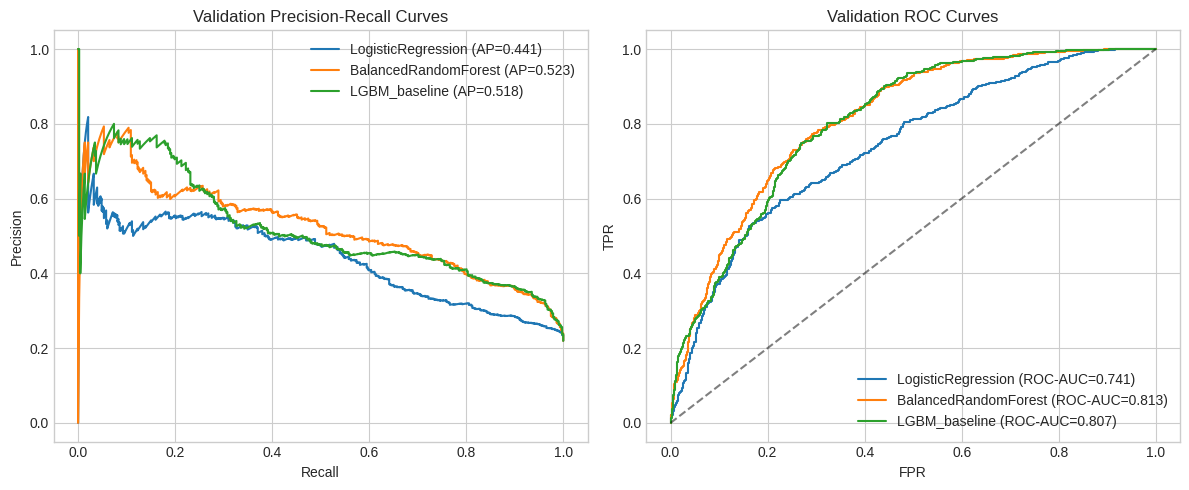

In [13]:
# Curves on validation set for baseline models
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
for name, score in valid_scores.items():
    p, r, _ = precision_recall_curve(y_valid, score)
    plt.plot(r, p, label=f"{name} (AP={average_precision_score(y_valid, score):.3f})")
plt.title('Validation Precision-Recall Curves')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.legend()

plt.subplot(1,2,2)
for name, score in valid_scores.items():
    fpr, tpr, _ = roc_curve(y_valid, score)
    plt.plot(fpr, tpr, label=f"{name} (ROC-AUC={roc_auc_score(y_valid, score):.3f})")
plt.plot([0,1],[0,1],'k--',alpha=0.5)
plt.title('Validation ROC Curves')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend()
plt.tight_layout(); plt.show()

## 5 — Hyperparameter tuning (optimize PR-AUC)

### 5A) Balanced Random Forest tuning (RandomizedSearchCV)

In [14]:
brf_pipe = Pipeline([
    ('prep', preprocessor_tree),
    ('model', BalancedRandomForestClassifier(random_state=SEED, n_jobs=-1))
])

param_dist = {
    'model__n_estimators': [200],
    'model__max_depth': [4, 8, 12],
    'model__min_samples_leaf': [3, 7],
    'model__max_features': ['sqrt', 'log2'],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
brf_search = RandomizedSearchCV(
    brf_pipe,
    param_distributions=param_dist,
    n_iter=30,
    scoring='average_precision',
    cv=cv,
    random_state=SEED,
    n_jobs=-1,
    verbose=1,
)
brf_search.fit(X_train, y_train)

best_brf = brf_search.best_estimator_
brf_valid_proba = best_brf.predict_proba(X_valid)[:,1]
print('Best BRF params:', brf_search.best_params_)
print('Best BRF CV AP:', brf_search.best_score_)
print('BRF validation AP:', average_precision_score(y_valid, brf_valid_proba))
print('BRF validation ROC-AUC:', roc_auc_score(y_valid, brf_valid_proba))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best BRF params: {'model__n_estimators': 200, 'model__min_samples_leaf': 7, 'model__max_features': 'sqrt', 'model__max_depth': 8}
Best BRF CV AP: 0.49342281460592785
BRF validation AP: 0.5402727135607039
BRF validation ROC-AUC: 0.8142462902642056


### 5B) LightGBM tuning with Optuna integration (LightGBMTunerCV)

In [16]:
X_train_lgb = preprocessor_tree.fit_transform(X_train)
X_valid_lgb = preprocessor_tree.transform(X_valid)
X_test_lgb = preprocessor_tree.transform(X_test)

if sparse.issparse(X_train_lgb):
    X_train_lgb = X_train_lgb.tocsr()
    X_valid_lgb = X_valid_lgb.tocsr()
    X_test_lgb = X_test_lgb.tocsr()

lgb_train = lgb.Dataset(X_train_lgb, label=y_train)

def lgb_avg_precision(preds, data):
    y_true = data.get_label()
    return 'avg_precision', average_precision_score(y_true, preds), True

callbacks = [
    lgb.early_stopping(stopping_rounds=40, verbose=False),
    lgb.log_evaluation(period=0),  # silence; set to 100 if you want occasional logs
]

params = {
    'objective': 'binary',
    'metric': 'avg_precision', # Changed from 'None' to 'avg_precision'
    'verbosity': -1,
    'seed': SEED,
    'feature_pre_filter': False,
}

tuner = optuna_lgb.LightGBMTunerCV(
    params=params,
    train_set=lgb_train,
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
    feval=lgb_avg_precision,
    num_boost_round=600,
    optuna_seed=SEED,
    time_budget=160,
    return_cvbooster=True,
    callbacks=callbacks
)
tuner.run()

best_params = tuner.best_params
best_iter =  tuner.get_best_booster().best_iteration
print('Best LGBM params:', best_params)
print('Best iteration:', best_iter)

final_lgb = lgb.train(best_params, lgb_train, num_boost_round= tuner.get_best_booster().best_iteration)
lgb_valid_proba = final_lgb.predict(X_valid_lgb)
print('LGBM validation AP:', average_precision_score(y_valid, lgb_valid_proba))
print('LGBM validation ROC-AUC:', roc_auc_score(y_valid, lgb_valid_proba))


[I 2026-02-22 15:38:15,468] A new study created in memory with name: no-name-f1e95aed-5ee3-4f07-bc4c-7ebbd7244f91
min_child_samples, val_score: 0.448255: 100%|##########| 5/5 [00:05<00:00,  1.18s/it]


Best LGBM params: {'objective': 'binary', 'metric': 'avg_precision', 'verbosity': -1, 'seed': 42, 'feature_pre_filter': False, 'lambda_l1': 6.376178057035216e-06, 'lambda_l2': 5.473223463236843e-07, 'num_leaves': 121, 'feature_fraction': 1.0, 'bagging_fraction': 0.4090780165040469, 'bagging_freq': 4, 'min_child_samples': 5}
Best iteration: 55
LGBM validation AP: 0.49804939528555514
LGBM validation ROC-AUC: 0.7934732778380987


**Note:** some LightGBM integration flows emphasize built-in metrics. Here we pass custom AP `feval` and still use external holdout AP for final selection.

## 6 — Calibration + thresholding

In [17]:
# Model selection uses VALIDATION AP only (no test leakage)
valid_candidates = {
    'BRF_tuned': brf_valid_proba,
    'LGBM_tuned': lgb_valid_proba,
}
best_model_name = max(valid_candidates, key=lambda n: average_precision_score(y_valid, valid_candidates[n]))
print('Selected by validation AP:', best_model_name)

# Refit selected model on train+valid, then evaluate ONCE on untouched test
X_train_full = pd.concat([X_train, X_valid], axis=0)
y_train_full = pd.concat([y_train, y_valid], axis=0)

if best_model_name == 'BRF_tuned':
    final_model = clone(best_brf)
    final_model.fit(X_train_full, y_train_full)
    test_scores = final_model.predict_proba(X_test)[:,1]
else:
    X_train_full_lgb = preprocessor_tree.fit_transform(X_train_full)
    X_test_full_lgb = preprocessor_tree.transform(X_test)
    if sparse.issparse(X_train_full_lgb):
        X_train_full_lgb = X_train_full_lgb.tocsr()
        X_test_full_lgb = X_test_full_lgb.tocsr()
    final_model = lgb.train(best_params, lgb.Dataset(X_train_full_lgb, label=y_train_full), num_boost_round=best_iter)
    test_scores = final_model.predict(X_test_full_lgb)

print('FINAL TEST AP:', average_precision_score(y_test, test_scores))
print('FINAL TEST ROC-AUC:', roc_auc_score(y_test, test_scores))

for k in [0.01, 0.05, 0.10]:
    print(precision_recall_at_k(y_test.values, test_scores, k))

def threshold_for_targeting_rate(scores, targeting_rate):
    k = max(1, int(np.floor(len(scores)*targeting_rate)))
    return float(np.sort(scores)[-k])

rate = 0.05
thr = threshold_for_targeting_rate(test_scores, rate)
print(f'Top {rate:.0%} targeting threshold:', thr)
print('At this targeting rate:', precision_recall_at_k(y_test.values, test_scores, rate))

Selected by validation AP: BRF_tuned
FINAL TEST AP: 0.5252135036051097
FINAL TEST ROC-AUC: 0.8107729311342592
{'k_frac': 0.01, 'k': 19, 'threshold': 0.8223710087389133, 'precision@k': 1.0, 'recall@k': 0.04398148148148148}
{'k_frac': 0.05, 'k': 98, 'threshold': 0.777145892978963, 'precision@k': 0.6530612244897959, 'recall@k': 0.14814814814814814}
{'k_frac': 0.1, 'k': 196, 'threshold': 0.7272458510480875, 'precision@k': 0.5969387755102041, 'recall@k': 0.2708333333333333}
Top 5% targeting threshold: 0.777145892978963
At this targeting rate: {'k_frac': 0.05, 'k': 98, 'threshold': 0.777145892978963, 'precision@k': 0.6530612244897959, 'recall@k': 0.14814814814814814}


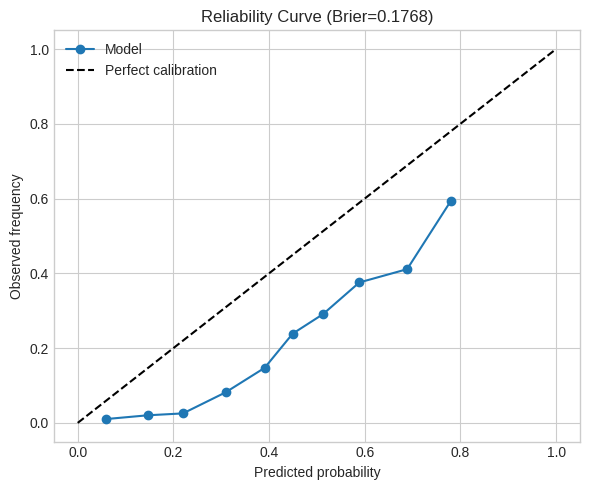

In [18]:
# Optional calibration check
prob_true, prob_pred = calibration_curve(y_test, test_scores, n_bins=10, strategy='quantile')
brier = brier_score_loss(y_test, test_scores)

plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0,1],[0,1],'k--', label='Perfect calibration')
plt.title(f'Reliability Curve (Brier={brier:.4f})')
plt.xlabel('Predicted probability')
plt.ylabel('Observed frequency')
plt.legend(); plt.tight_layout(); plt.show()

## 7 — Interpretability

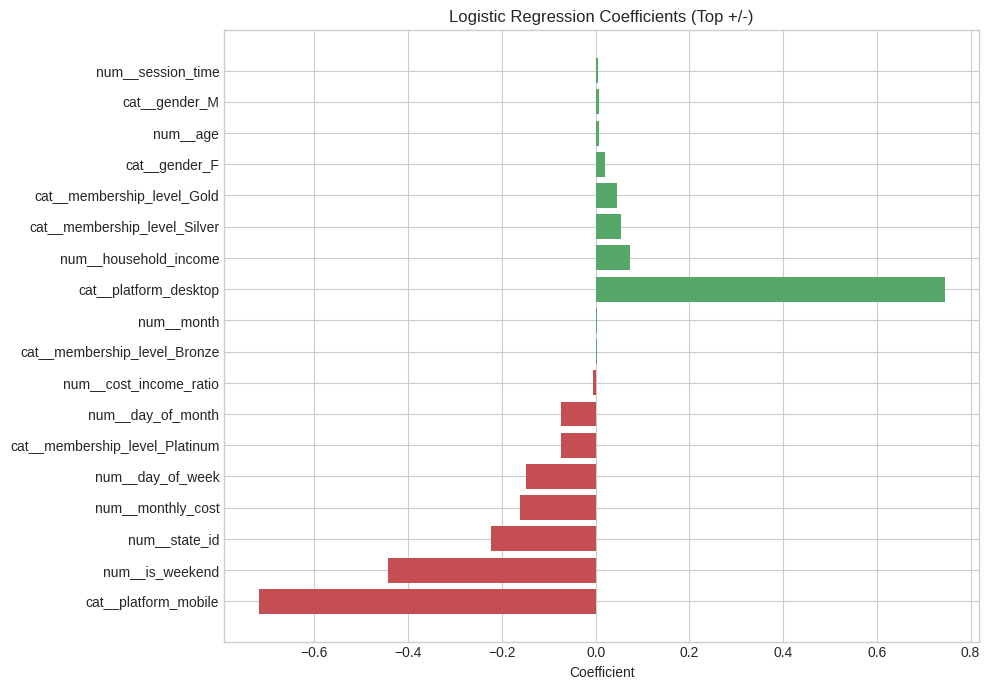

In [19]:
# Logistic coefficients (fit on train+valid for interpretability)
logit_pipe = Pipeline([
    ('prep', preprocessor_scaled),
    ('model', LogisticRegression(max_iter=3000, class_weight='balanced', random_state=SEED))
])
logit_pipe.fit(X_train_full, y_train_full)
feat_names = logit_pipe.named_steps['prep'].get_feature_names_out()
coefs = logit_pipe.named_steps['model'].coef_.ravel()
coef_df = pd.DataFrame({'feature': feat_names, 'coef': coefs})
plot_df = pd.concat([coef_df.nsmallest(10, 'coef'), coef_df.nlargest(10, 'coef')])

plt.figure(figsize=(10,7))
colors = ['#C44E52' if x < 0 else '#55A868' for x in plot_df['coef']]
plt.barh(plot_df['feature'], plot_df['coef'], color=colors)
plt.title('Logistic Regression Coefficients (Top +/-)')
plt.xlabel('Coefficient')
plt.tight_layout(); plt.show()

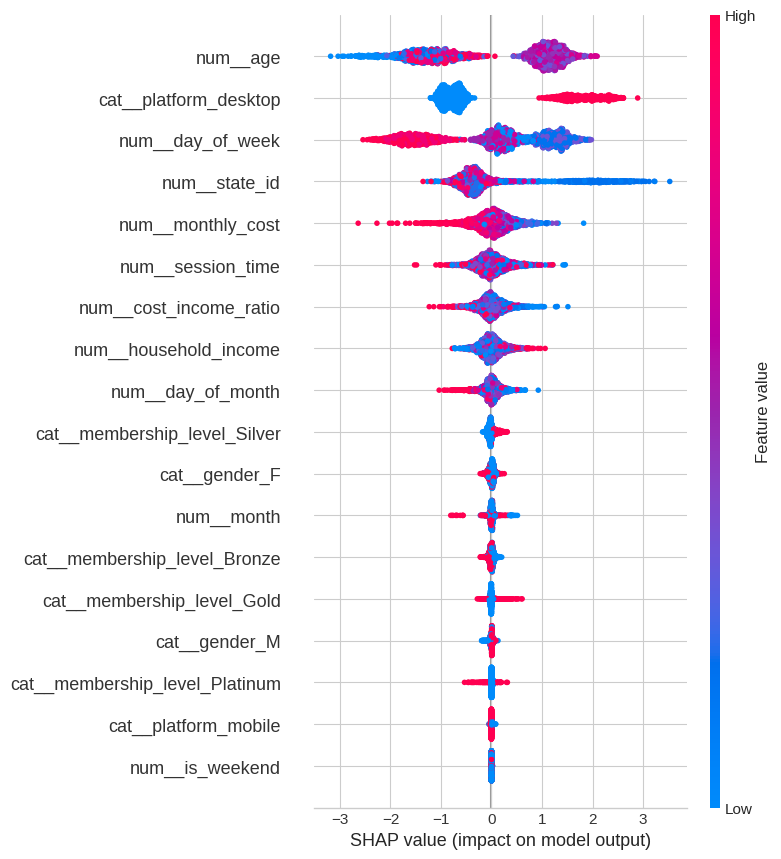

In [20]:
# SHAP summary for final LightGBM (when selected), otherwise for a reference LGBM fit
if best_model_name != 'LGBM_tuned':
    X_train_full_lgb = preprocessor_tree.fit_transform(X_train_full)
    if sparse.issparse(X_train_full_lgb):
        X_train_full_lgb = X_train_full_lgb.tocsr()
    ref_lgb = lgb.train({'objective':'binary','verbosity':-1,'seed':SEED}, lgb.Dataset(X_train_full_lgb, label=y_train_full), num_boost_round=300)
    shap_model = ref_lgb
    X_shap_pool = X_train_full_lgb
else:
    shap_model = final_model
    X_shap_pool = preprocessor_tree.transform(X_test)
    if sparse.issparse(X_shap_pool):
        X_shap_pool = X_shap_pool.tocsr()

sample_n = min(2000, X_shap_pool.shape[0])
idx = np.random.choice(X_shap_pool.shape[0], size=sample_n, replace=False)
X_shap = X_shap_pool[idx]

explainer = shap.TreeExplainer(shap_model)
shap_values = explainer.shap_values(X_shap)
if isinstance(shap_values, list):
    shap_values = shap_values[1]

shap.summary_plot(shap_values, X_shap, feature_names=preprocessor_tree.get_feature_names_out(), show=True)

**Business interpretation:** use the top model’s SHAP ranking and logistic signs to identify which user patterns increase conversion propensity. Execute campaigns with top-K thresholds (e.g., 5%) for controlled outreach volume.

## 8 — Save artifacts + inference example

In [21]:
# Persist artifacts
joblib.dump(preprocessor_scaled, 'preprocessor_scaled.joblib')
joblib.dump(preprocessor_tree, 'preprocessor_tree.joblib')
joblib.dump(best_brf, 'balanced_random_forest_tuned.joblib')

if best_model_name == 'LGBM_tuned':
    final_model.save_model('lightgbm_tuned.txt')
else:
    # Save a reference lgbm too for reproducibility if BRF selected
    X_train_full_lgb = preprocessor_tree.fit_transform(X_train_full)
    if sparse.issparse(X_train_full_lgb):
        X_train_full_lgb = X_train_full_lgb.tocsr()
    ref_lgb = lgb.train({'objective':'binary','verbosity':-1,'seed':SEED}, lgb.Dataset(X_train_full_lgb, label=y_train_full), num_boost_round=300)
    ref_lgb.save_model('lightgbm_reference.txt')

print('Artifacts saved.')

Artifacts saved.


In [22]:
# Inference output: top-k propensity users in TEST (id + probability)
id_test = work_df.loc[idx_test, [ID_COL]].reset_index(drop=True)
out = id_test.copy()
out['propensity_score'] = test_scores
out = out.sort_values('propensity_score', ascending=False).reset_index(drop=True)

k_show = 20
display(out.head(k_show))

,id,propensity_score
0,8608,0.874274
1,5583,0.868457
2,212,0.862158
3,6863,0.856586
4,7770,0.854735
5,4425,0.854613
6,3130,0.852093
7,8673,0.845760
8,898,0.845489
9,6049,0.844470
